In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model

In [2]:

def Nomalizaion_datas(df):
        # 훈련시킬 데이터와, 학습후 결과를 확인할 데이터 분리
    df = df.loc[df['Date']<="2021"]
    df.sort_index(ascending=False).reset_index(drop=True)

    #정규화하기
    scaler = MinMaxScaler()
    scale_cols = ['시가', '고가', '저가', '현재가', '거래량', '거래대금', 'D', 'G',
        'O', 'Dow', 'kosdaq', 'nasdaq', 'S&P500']
    df_scaled = scaler.fit_transform(df[scale_cols])
    df_scaled = pd.DataFrame(df_scaled)
    df_scaled.columns = scale_cols
    
    # 테스트사이즈, 윈도우사이즈 설정
    TEST_SIZE = 200
    WINDOW_SIZE = 20

    #--------------------------------------------------------
    train = df_scaled[:-TEST_SIZE]
    test = df_scaled[-TEST_SIZE:]

    test.reset_index(drop=True, inplace=True)
    
    return  train, test


def make_dataset(data, label, window_size=20):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    
    return np.array(feature_list), np.array(label_list)


 
def training_target(train):
    
    feature_cols = ['시가', '고가', '저가', '거래량', '거래대금', 'D', 'G',
            'O', 'kosdaq']
    label_cols = ['현재가']

    train_feature = train[feature_cols]
    train_label = train[label_cols]

    train_feature, train_label = make_dataset(train_feature, train_label, 20)

    x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.2)
    
    return x_train, x_valid, y_train, y_valid, feature_cols, label_cols, train_feature, train_label

  
def test_feature_label(feature_cols, label_cols):
    test_feature = test[feature_cols]
    test_label = test[label_cols]

    X_test, y_test = make_dataset(test_feature, test_label, 20)
    
    return X_test, y_test, test_feature, test_label

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM , Conv1D, Dropout, GRU
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# 모델 생성

In [4]:
df = pd.read_excel("data_kosdaq_price_OGD/티씨케이.xlsx.xlsx")
train, test= Nomalizaion_datas(df)
x_train, x_valid, y_train, y_valid, feature_cols, label_cols, train_feature, train_label = training_target(train)
X_test, y_test, test_feature, test_label = test_feature_label(feature_cols, label_cols)

In [9]:
  model = Sequential()
  model.add(GRU(units = 480, 
             input_shape=(train_feature.shape[1], train_feature.shape[2]), 
             activation='relu', 
             return_sequences=True))
  model.add(GRU(units = 448,
             input_shape=(train_feature.shape[1], train_feature.shape[2]), 
             activation='relu', 
             return_sequences=True))
  model.add(GRU(units = 96,  
             activation='relu', 
             return_sequences=True))
  model.add(LSTM(units = 480, activation="relu"))
  model.add(Dropout(0.2))
  model.add(Dense(1,activation='relu',))
  optimizer_2 = Adam(0.005)
  model.compile(loss='mean_squared_error', optimizer=optimizer_2, metrics=["accuracy"])
  early_stop = EarlyStopping(monitor='val_loss', patience=30)


In [10]:
model_path = 'model'
filename = os.path.join(model_path, '티씨케이.h5')
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

with tf.device("/device:GPU:0"):
    history = model.fit(x_train, y_train, epochs=50, batch_size=32, shuffle=False, callbacks=[early_stop, checkpoint], validation_data=(x_valid, y_valid))
    model.save('티씨케이.h5')
    model.reset_states()

Epoch 1/50
38/38 [==============================] - 6s 74ms/step - loss: 0.0058 - accuracy: 8.4034e-04 - val_loss: 0.0011 - val_accuracy: 0.0000e+00

Epoch 00001: val_loss improved from inf to 0.00107, saving model to model/테스나.h5
Epoch 2/50
38/38 [==============================] - 3s 70ms/step - loss: 9.8315e-04 - accuracy: 8.4034e-04 - val_loss: 4.5744e-04 - val_accuracy: 0.0000e+00

Epoch 00002: val_loss improved from 0.00107 to 0.00046, saving model to model/테스나.h5
Epoch 3/50
38/38 [==============================] - 3s 72ms/step - loss: 7.1229e-04 - accuracy: 8.4034e-04 - val_loss: 8.3726e-04 - val_accuracy: 0.0000e+00

Epoch 00003: val_loss did not improve from 0.00046
Epoch 4/50
38/38 [==============================] - 3s 73ms/step - loss: 0.0012 - accuracy: 8.4034e-04 - val_loss: 7.2566e-04 - val_accuracy: 0.0000e+00

Epoch 00004: val_loss did not improve from 0.00046
Epoch 5/50
38/38 [==============================] - 3s 76ms/step - loss: 6.3572e-04 - accuracy: 8.4034e-04 - val

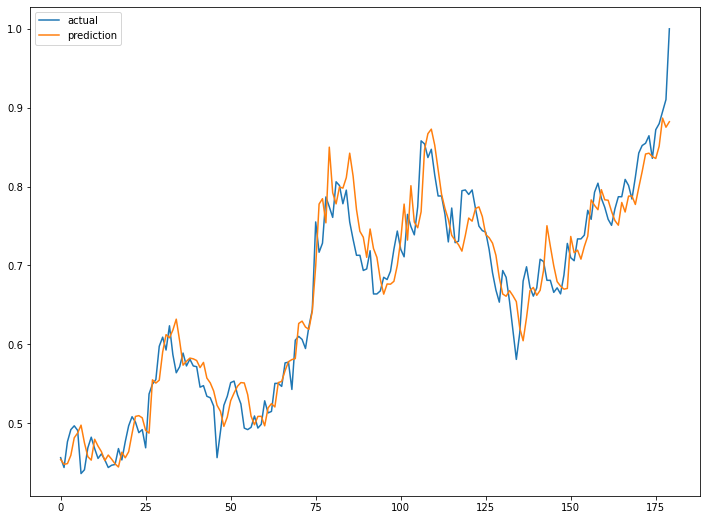

In [11]:
model.load_weights(filename)
pred = model.predict(X_test)
plt.figure(figsize=(12, 9))
plt.plot(y_test, label = 'actual')
plt.plot(pred, label = 'prediction')
plt.legend()
plt.show()

In [12]:
from sklearn.metrics import mean_squared_error, r2_score

mean_squared_error(y_test, pred), r2_score(y_test, pred)

(0.0011258960300740506, 0.9311730582687576)